### 矢量数据与栅格数据相互转换

#### 1. 栅格数据矢量化

In [9]:
import rasterio as rio
import matplotlib.pyplot as plt


In [10]:
path_mndwi_thre = 'data/section-6/s2_20m_6bands_chenggong_mndwi_thre016.tif'   # 栅格数据


In [11]:
with rio.open(path_mndwi_thre) as src:
    arr = src.read(1)
    transform = src.transform
    crs = src.crs
print(crs)
# print(transform)
# print(arr.shape)

# rsimg_rio = rio.open(path_mndwi_thre)
# arr = rsimg_rio.read(1)
# transform = rsimg_rio.transform
# crs = rsimg_rio.crs
# crs


EPSG:32648


In [12]:
import numpy as np
print(np.unique(arr))
arr[arr<-100000]=np.nan
print(np.unique(arr))

[0. 1.]
[0. 1.]


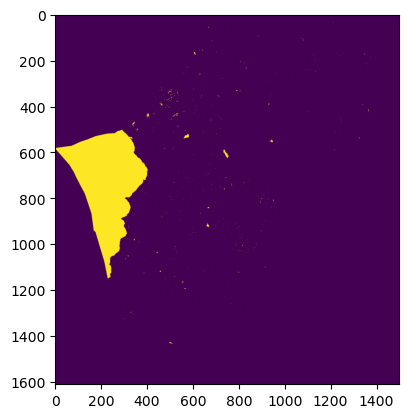

In [13]:
plt.imshow(arr)

In [14]:
from rasterio import features
from shapely import Polygon

## 将二值图像转为几何图形顶点坐标
geos_values = features.shapes(arr, transform=transform)   ## generator
print(next(geos_values))
## 分别获取几何面和几何面对应的像元值
geos, values = [], []
for geo, value in geos_values:
    geos.append(geo['coordinates'])
    values.append(value)

geos = [Polygon(geo[0]) for geo in geos]  ## 由序列坐标转为几何面


({'type': 'Polygon', 'coordinates': [[(292380.0, 2764720.0), (292380.0, 2764700.0), (292400.0, 2764700.0), (292400.0, 2764720.0), (292380.0, 2764720.0)]]}, 1.0)


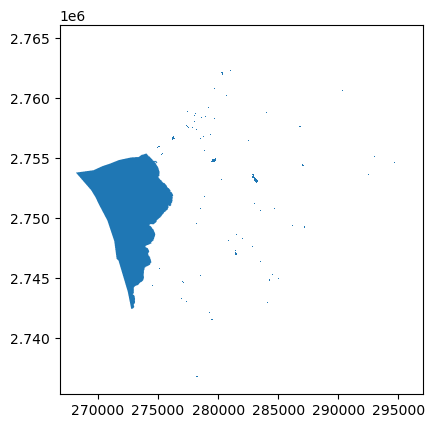

In [ ]:
import geopandas as gpd
## 将获取的几何面和像元值创建为geopandas.dataframe数据类型。
poly_gdf = gpd.GeoDataFrame({'value':values, 'geometry':geos}, crs=crs)
poly_gdf = poly_gdf[poly_gdf.value==1] ## 只保留值为1的几何面
poly_gdf.plot()
# poly_gdf.to_file('data/section-6/chenggong_mndwi_thre_vec.gpkg', driver='GPKG')



#### 2. 矢量数据栅格化

In [16]:
import geopandas as gpd
import rasterio as rio
from rasterio import features     
import matplotlib.pyplot as plt
import numpy as np


In [17]:
path_vec = 'data/section-6/chenggong_mndwi_thre_vec.gpkg'


   value                                           geometry
0    1.0  POLYGON ((2.92e+05 2.76e+06, 2.92e+05 2.76e+06...
1    1.0  POLYGON ((2.83e+05 2.76e+06, 2.83e+05 2.76e+06...
2    1.0  POLYGON ((2.82e+05 2.76e+06, 2.82e+05 2.76e+06...
3    1.0  POLYGON ((2.86e+05 2.76e+06, 2.86e+05 2.76e+06...
4    1.0  POLYGON ((2.86e+05 2.76e+06, 2.86e+05 2.76e+06...


<Axes: >

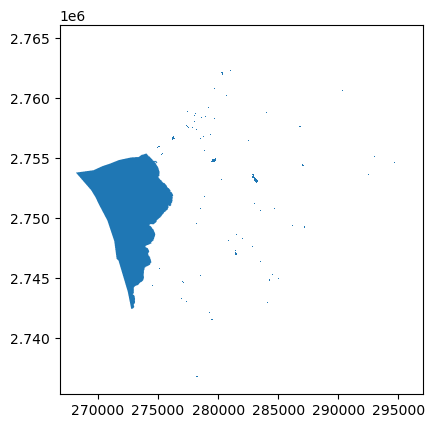

In [20]:
vec_gpd = gpd.read_file(path_vec)
print(vec_gpd.head())
vec_gpd.plot()


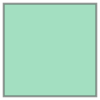

In [21]:
## 遍历几何
geos = []
for geo in vec_gpd.geometry:
    geos.append(geo)
geos[1]

In [22]:
### 矢量转栅格，需要一个参考栅格，提供分辨率、转换参数等信息
path_base_raster = 'data/section-6/s2_20m_6bands_chenggong_mndwi_thre016.tif'  ## (1)能覆盖矢量数据范围,(2)相同坐标系
raster = rio.open(path_base_raster)
print(raster.bounds)
print(raster.res)
raster.meta


BoundingBox(left=268180.0, bottom=2733220.0, right=298120.0, top=2765440.0)
(20.0, 20.0)


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1497,
 'height': 1611,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]'),
 'transform': Affine(20.0, 0.0, 268180.0,
        0.0, -20.0, 2765440.0)}

In [32]:
### (1) 仅根据矢量数据几何信息进行栅格化
rasterized = features.rasterize(shapes=geos,
                                out_shape = raster.shape,    ## 此处.shape获取二维形状
                                fill = 0,  ## 栅格化填充值
                                transform = raster.transform,
                                default_value = 1  # 几何体填充值
                                )


In [24]:
np.unique(rasterized)


array([0, 1])

可视化栅格化结果

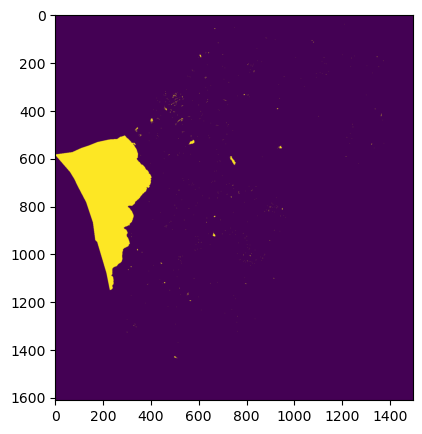

In [25]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
ax.imshow(rasterized)


In [ ]:
### 矢量数据对特定属性值进行栅格化 （自行学习）
# vec_gpd['id'] = vec_gpd.index ## 添加属性
# geos_values = zip(list(vec_gpd['geometry']), list(vec_gpd['id']))
# geos_values = list(geos_values)
# # Rasterize vector using the shape and transform of the raster
# rasterized_2 = features.rasterize(shapes=geos_values,
#                                 out_shape = raster.shape,
#                                 transform = raster.transform,
#                                 fill = 0,   # background value
#                                 )


In [33]:
# fig, ax = plt.subplots(1,1, figsize = (5, 5))
# ax.imshow(rasterized_2)


写出栅格化数据

In [34]:
path_raster_save = 'data/section-6/chenggong_mndwi_thre_vec_raster.tif'
with rio.open(path_raster_save, 'w', 
                driver=raster.driver, 
                height=raster.height,
                width=raster.width,
                count=1,
                dtype=np.int16,
                crs=raster.crs,
                transform=raster.transform) as dst:
  dst.write(rasterized, 1)    ## the number 1 is the number of bands.
